In [7]:
!rm -r *
!git clone https://github.com/LudoRey/dip-deblur/
!mv dip-deblur/* ./
!rm -r dip-deblur


Cloning into 'dip-deblur'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 40 (delta 15), reused 33 (delta 9), pack-reused 0
Unpacking objects: 100% (40/40), 466.25 KiB | 8.04 MiB/s, done.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import skimage as sk
from skimage.metrics import peak_signal_noise_ratio as psnr
from unet import *
from utils import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

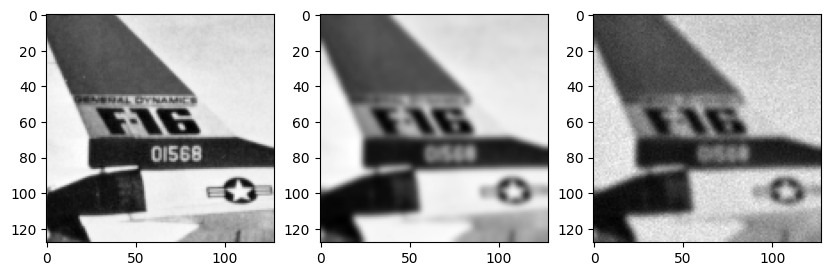

In [2]:
# Read image and create degraded version

im = read_img('data/airplane.tif', as_tensor=True).to(device)
ker = gaussian_kernel(sigma=1.5, as_tensor=True).to(device)

im_blur = blur(im, ker)
im_blur_noisy = poisson_noise(im_blur, peak=1e3)

#im_blur_noisy = read_img('data/veil128_stretched.tif', as_tensor=True).to(device)
#ker = read_img('data/veil128_psf.tif', as_tensor=True).to(device)

fig, axes = plt.subplots(1,3, figsize=(10,5))
axes[0].imshow(display(im), cmap='gray')
axes[1].imshow(display(im_blur), cmap='gray')
axes[2].imshow(display(im_blur_noisy), cmap='gray')
plt.show()

In [8]:
nb_epoch = 2000
learning_rate = 0.01
#input = torch.rand(1,32,128,128)/10
input = im_blur_noisy
net_params = {
    'down_channels' : 128,
    'up_channels' : 128,
    'skip_channels' : 4,
    'depth' : 4
}

# Create network
model = Unet(in_channels=input.shape[1], out_channels=1, **net_params)
model = model.to(device)

# Create loss function and optimizer
criterion = nn.MSELoss()
criterion = CsiszarDiv()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
# Optimizing loop
model.train()
for i_epoch in range(nb_epoch):
    optimizer.zero_grad()
    im_recon = model(input)
    loss = criterion(blur(im_recon, ker), im_blur_noisy)
    metric = psnr(im, im_recon)
    loss.backward()
    optimizer.step()
    if (i_epoch+1) % 100 == 0:
        print(' [-] epoch {:}/{:}, loss {:.6f}, psnr {:.5f}'.format(i_epoch+1, nb_epoch, loss.item(), metric))

TypeError: ignored

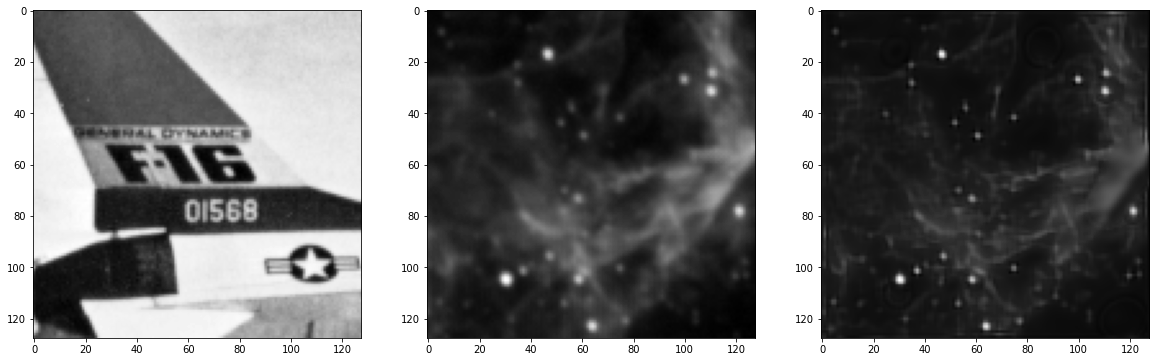

In [ ]:

fig, axes = plt.subplots(1,3, figsize=(20,30))
axes[0].imshow(display(im), cmap='gray')
axes[1].imshow(display(im_blur_noisy), cmap='gray')
axes[2].imshow(display(im_recon), cmap='gray')
plt.show()

In [ ]:
im_recon_blur = F.conv2d(im_recon, ker, padding='same')
fig, axes = plt.subplots(1,2, figsize=(10,20))
axes[0].imshow(display(im_blur), cmap='gray')
axes[1].imshow(display(im_recon_blur), cmap='gray')